In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU

2025-01-31 15:37:46.151379: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 15:37:46.977354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738337867.308570   26757 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738337867.365796   26757 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 15:37:48.095980: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# GradCAM Function

In [2]:
def preprocess_image(img_path, target_size):
    # Add error handling for file existence
    try:
        img = tf.keras.preprocessing.image.load_img(
            img_path, 
            color_mode='grayscale', 
            target_size=target_size
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize to [0, 1]
        return np.expand_dims(img_array, axis=0)
    except Exception as e:
        raise Exception(f"Error loading image: {str(e)}")

def generate_gradcam(image_path, model, grad_model, target_size=(51, 51)):
    # Load and preprocess the image
    image = preprocess_image(image_path, target_size)
    
    # Get the prediction
    predictions = model(image)
    predicted_class = 1 if predictions[0] > 0.5 else 0
    print(f"Predicted class: {predicted_class} (confidence: {predictions[0][0]:.3f})")
    
    # Generate gradients
    with tf.GradientTape() as tape:
        inputs = tf.cast(image, tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, 0]
    
    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        raise ValueError("Gradients are None. Check model architecture.")
    
    # Calculate pooled gradients and heatmap
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    
    # Process heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    
    # Load and process original image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Failed to load image for visualization")
    
    # Resize heatmap to match original image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    
    # Convert grayscale to RGB for visualization
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # Create superimposed image
    superimposed = cv2.addWeighted(img_rgb, 0.6, heatmap_colored, 0.4, 0)
    
    return superimposed, heatmap_resized, predicted_class, predictions[0][0]

# AlexNet

In [3]:
# First, load your saved model
original_model = tf.keras.models.load_model('alex_net_auc53_2.keras')

# Get the weights from the original model
weights = original_model.get_weights()

# Rebuild the model with explicit input layer
inputs = tf.keras.Input(shape=(51, 51, 1))
x = tf.keras.layers.Conv2D(96, (6,6), strides=4, activation='relu', name='conv2d')(inputs)
x = tf.keras.layers.MaxPooling2D((3,3), strides=2, name='max_pooling2d')(x)
x = tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu', padding='same', name='conv2d_1')(x)
x = tf.keras.layers.MaxPooling2D((3,3), strides=2, name='max_pooling2d_1')(x)
x = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu', padding='same', name='conv2d_2')(x)
x = tf.keras.layers.Conv2D(384, (3,3), strides=1, activation='relu', padding='same', name='conv2d_3')(x)
x = tf.keras.layers.Conv2D(256, (3,3), strides=1, activation='relu', padding='same', name='conv2d_4')(x)
x = tf.keras.layers.MaxPooling2D((2,2), strides=2, name='max_pooling2d_2')(x)
x = tf.keras.layers.Flatten(name='flatten')(x)
x = tf.keras.layers.Dropout(0.5, name='dropout')(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='dense')(x)
x = tf.keras.layers.Dropout(0.5, name='dropout_1')(x)
x = tf.keras.layers.Dense(4096, activation='relu', name='dense_1')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='dense_2')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.set_weights(weights)

2025-01-31 15:38:05.445340: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
print(model.summary())

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 51, 51, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 12, 12, 96)     │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 5, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5, 5, 256)      │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,160,673 (80.72 MB)

 Trainable params: 21,160,673 (80.72 MB)

 Non-trainable params: 0 (0.00 B)

None


Predicted class: 0 (confidence: 0.030)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_105']
Received: inputs=Tensor(shape=(1, 51, 51, 1))
  warnings.warn(msg)


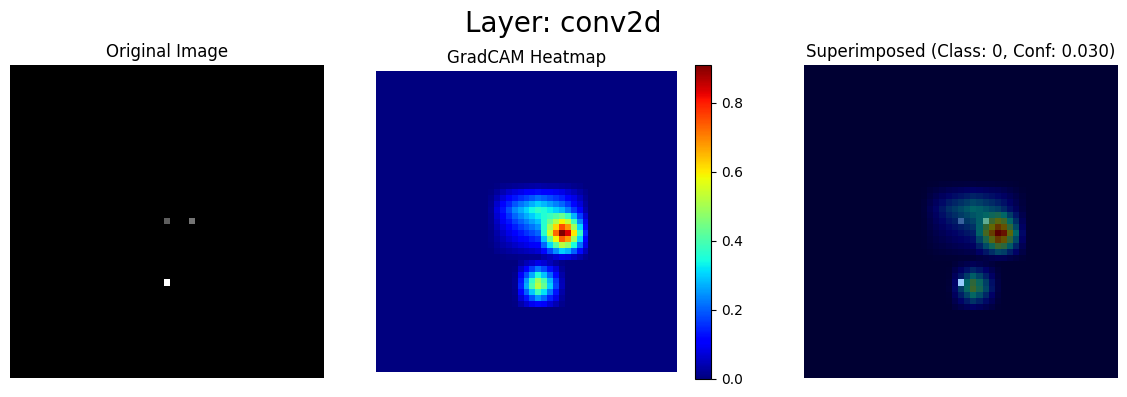

In [5]:
try:
    # Creating the grad model
    last_layer_name = 'conv2d'
    grad_model = tf.keras.Model(
        inputs=[model.input],
        outputs=[
            model.get_layer(last_layer_name).output,
            model.output
        ]
    )
except Exception as e:
    print(f"Error generating GradModel: {str(e)}")
    


try:
    image_path = "/teamspace/studios/this_studio/EFlow Images/btagged_images_CNN/btagged_images/background/record_859.png"
    
    # Generate GradCAM
    superimposed_img, heatmap, pred_class, confidence = generate_gradcam(
        image_path, 
        original_model, 
        grad_model
    )
    
    # Plotting
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Layer: {last_layer_name}', fontsize = 20)
    # Original image
    plt.subplot(131)
    plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Heatmap
    plt.subplot(132)
    plt.imshow(heatmap, cmap='jet')
    plt.title('GradCAM Heatmap')
    plt.colorbar()
    plt.axis('off')
    
    # Superimposed
    plt.subplot(133)
    plt.imshow(superimposed_img[..., ::-1])  # Convert BGR to RGB
    plt.title(f'Superimposed (Class: {pred_class}, Conf: {confidence:.3f})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error generating GradCAM: {str(e)}")

# Model 2

In [6]:
original_model2 = tf.keras.models.load_model('model2_auc57_4.keras')

weights = original_model2.get_weights()

inputs = Input(shape=(51, 51, 1))

x = Conv2D(128, (3,3), strides=1, activation='relu')(inputs)
x = MaxPooling2D(strides=1)(x)  # 2x2 filter by default
x = Conv2D(64, (3,3), strides=1, activation='relu')(x)
x = MaxPooling2D()(x)  # 2x2 filter, strides=2 by default
x = Conv2D(32, (3,3), strides=1, activation='relu')(x)
x = MaxPooling2D(strides=1, padding='same')(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
model2.set_weights(weights)

In [7]:
model2.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 51, 51, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 49, 49, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,612,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,721 (14.14 MB)

 Trainable params: 3,706,721 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

Predicted class: 1 (confidence: 0.893)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_165']
Received: inputs=Tensor(shape=(1, 51, 51, 1))
  warnings.warn(msg)


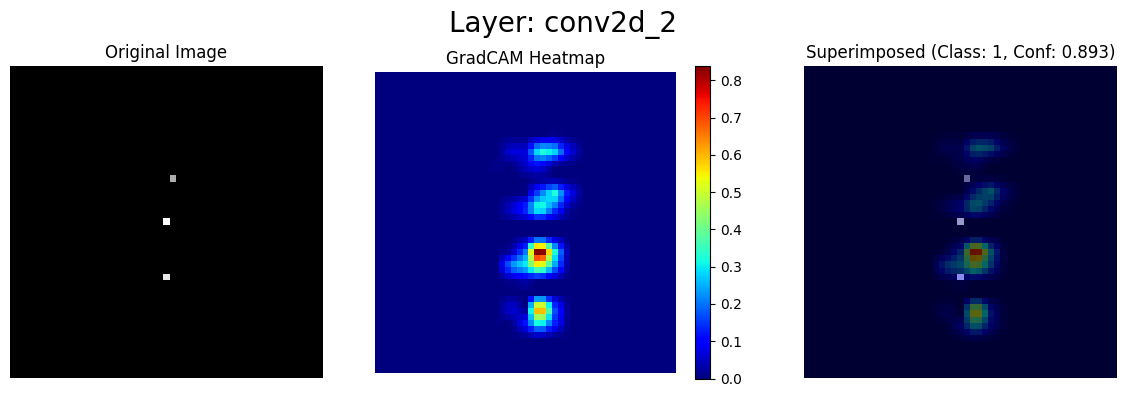

In [9]:
try:
    # Creating the grad model
    last_layer_name = 'conv2d_2'
    grad_model2 = tf.keras.Model(
        inputs=[model2.input],
        outputs=[
            model2.get_layer(last_layer_name).output,
            model2.output
        ]
    )
except Exception as e:
    print(f"Error generating GradModel: {str(e)}")
    


try:
    image_path = "/teamspace/studios/this_studio/EFlow Images/btagged_images_CNN/btagged_images/signal/record_675.png"
    
    # Generate GradCAM
    superimposed_img, heatmap, pred_class, confidence = generate_gradcam(
        image_path, 
        original_model2, 
        grad_model2
    )
    
    # Plotting
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Layer: {last_layer_name}', fontsize = 20)
    # Original image
    plt.subplot(131)
    plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Heatmap
    plt.subplot(132)
    plt.imshow(heatmap, cmap='jet')
    plt.title('GradCAM Heatmap')
    plt.colorbar()
    plt.axis('off')
    
    # Superimposed
    plt.subplot(133)
    plt.imshow(superimposed_img[..., ::-1])  # Convert BGR to RGB
    plt.title(f'Superimposed (Class: {pred_class}, Conf: {confidence:.3f})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error generating GradCAM: {str(e)}")

# Model 3: Single Convolution Layer

In [35]:
original_model3 = tf.keras.models.load_model('model3_auc55_7.keras')

weights = original_model3.get_weights()
inputs = Input(shape=(51, 51, 1))

x = Conv2D(128, (5, 5), strides=1)(inputs)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=1)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs)
model3.set_weights(weights)

In [36]:
model3.summary()

Model: "functional_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 51, 51, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 47, 47, 128)    │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 47, 47, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 46, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 270848)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    69,337,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,340,929 (264.51 MB)

 Trainable params: 69,340,929 (264.51 MB)

 Non-trainable params: 0 (0.00 B)

Predicted class: 0 (confidence: 0.000)


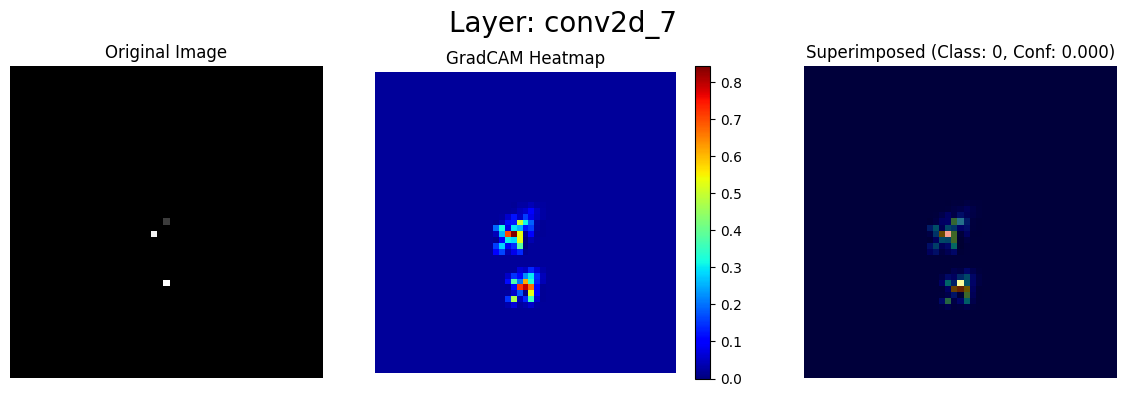

In [50]:
try:
    # Creating the grad model
    last_layer_name = 'conv2d_7'
    grad_model3 = tf.keras.Model(
        inputs=[model3.input],
        outputs=[
            model3.get_layer(last_layer_name).output,
            model3.output
        ]
    )
except Exception as e:
    print(f"Error generating GradModel: {str(e)}")
    


try:
    image_path = "/teamspace/studios/this_studio/EFlow Images/btagged_images_CNN/btagged_images/background/record_1209.png"
    
    # Generate GradCAM
    superimposed_img, heatmap, pred_class, confidence = generate_gradcam(
        image_path, 
        model3, 
        grad_model3
    )
    
    # Plotting
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Layer: {last_layer_name}', fontsize = 20)
    # Original image
    plt.subplot(131)
    plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Heatmap
    plt.subplot(132)
    plt.imshow(heatmap, cmap='jet')
    plt.title('GradCAM Heatmap')
    plt.colorbar()
    plt.axis('off')
    
    # Superimposed
    plt.subplot(133)
    plt.imshow(superimposed_img[..., ::-1])  # Convert BGR to RGB
    plt.title(f'Superimposed (Class: {pred_class}, Conf: {confidence:.3f})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error generating GradCAM: {str(e)}")